In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import DivergingNorm
import seaborn as sns

# 1. Read in master spreadsheet

In [2]:
master = pd.read_csv('../utils/point_muts.csv', index_col=0, header=[0,1])

# 2. Create residual scores

In [3]:
def create_resid_scores(point_muts):
    """
    Create residual scores.
    
    Args:
        point_muts: DataFrame of point mutant scores in Radicicol and Zero conditions
    Returns:
        resid_scores: residuals (np array)
        rad_scores: variant scores in radicicol (np array, float64)
        dmso_scores: variant scores in vehicle (DMSO) (np array, float64)
        coef: coefficients of linear regression (np array)
        poly1d_fn: linear regression function (np poly1d)
    """
    
    # Get radicicol and DMSO scores
    rad_scores = point_muts.loc[:, ('Radicicol', 'score')].values
    dmso_scores = point_muts.loc[:, ('Zero', 'score')].values
    
    # Fit linear regression
    coef = np.polyfit(dmso_scores, rad_scores, 1)
    poly1d_fn = np.poly1d(coef) 
    
    # Calculate residuals
    resid_scores = rad_scores - poly1d_fn(rad_scores)
    
    return(resid_scores, rad_scores, dmso_scores, coef, poly1d_fn)

In [4]:
def create_resid_scores_from_array(rad_scores, dmso_scores):
    """
    Create residual scores.
    
    Args:
        rad_scores: variant scores in radicicol (np array, float64)
        dmso_scores: variant scores in vehicle (DMSO) (np array, float64)
        point_muts: DataFrame of point mutant scores in Radicicol and Zero conditions
    Returns:
        resid_scores: residuals (np array)
        coef: coefficients of linear regression (np array)
        poly1d_fn: linear regression function (np poly1d)
    """
    
    # Fit linear regression
    coef = np.polyfit(dmso_scores, rad_scores, 1)
    poly1d_fn = np.poly1d(coef) 
    
    # Calculate residuals
    resid_scores = rad_scores - poly1d_fn(rad_scores)
    
    return(resid_scores, coef, poly1d_fn)

In [5]:
resid_scores, rad_scores, dmso_scores, coef, poly1d_fn = create_resid_scores(master)

# 3. Scale scores like in Envision and scale to [-1, 1]

In [6]:
def envision_scale(scores):
    """
    Scale scores like in Envision (Gray 2018).
    
    Args:
        scores: DMS scores (np array)
    Returns
        scaled_scores: scores scaled like in Envision
    
    """
    
    # Get median scores
    median_score = np.median(scores)

    bottom_1pct_score = scores[scores < np.percentile(scores, 1)]
    median_bottom_score = np.median(bottom_1pct_score)

    # Scale according to Envision scaling
    scaled_scores = ((scores - median_score) / -median_bottom_score)  + 1
    
    return(scaled_scores)

In [7]:
envision_rad_scores = envision_scale(rad_scores)
envision_dmso_scores = envision_scale(dmso_scores)

In [8]:
rad_scores_11 = rad_scores / abs(rad_scores).max()
dmso_scores_11 = dmso_scores / abs(dmso_scores).max()

# 4. Calculate differential selection like in Phillips 2018 paper

In [9]:
def phillips_scoring(rad_scores, dmso_scores):
    """
    Calculate differential selection as in Phillips 2018.
    
    Args:
        rad_scores: scores in radicicol (np array)
        dmso_scores: scores in vehicle (DMSO) (np array)
    Returns:
        diffsel: difference between scores (np array)
        
    """
    
    diffsel = rad_scores - dmso_scores
    return(diffsel)

In [10]:
diffsel_scores = phillips_scoring(rad_scores, dmso_scores)

# 5. Visualize rescaled scores

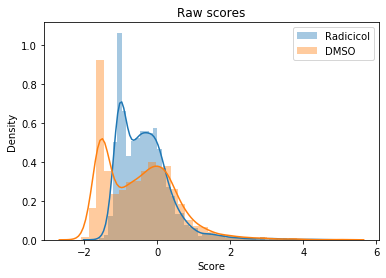

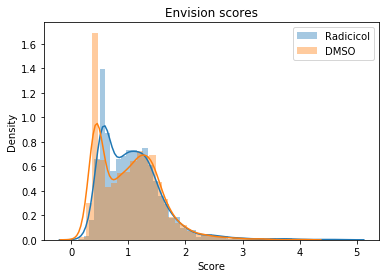

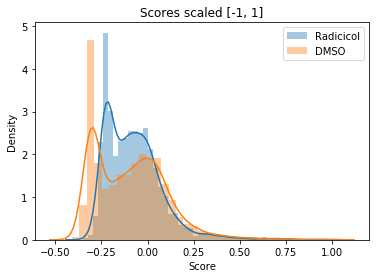

In [11]:
sns.distplot(rad_scores, label='Radicicol')
sns.distplot(dmso_scores, label='DMSO')
plt.legend()
plt.title('Raw scores')
plt.xlabel('Score')
plt.ylabel('Density')
plt.show()

sns.distplot(envision_rad_scores, label='Radicicol')
sns.distplot(envision_dmso_scores, label='DMSO')
plt.legend()
plt.title('Envision scores')
plt.xlabel('Score')
plt.ylabel('Density')
plt.show()

sns.distplot(rad_scores_11, label='Radicicol')
sns.distplot(dmso_scores_11, label='DMSO')
plt.legend()
plt.title('Scores scaled [-1, 1]')
plt.xlabel('Score')
plt.ylabel('Density')
plt.show()

# 6. Compare residuals and differential selection of raw, Envision, and [-1, 1] scaled scores

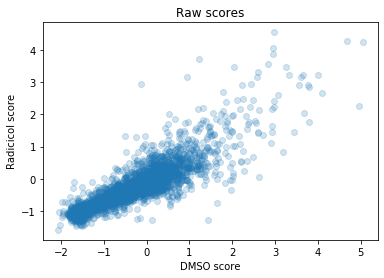

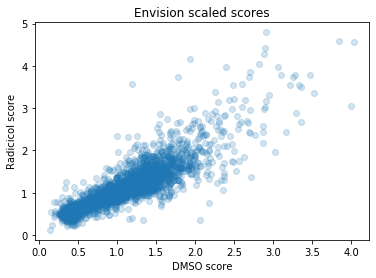

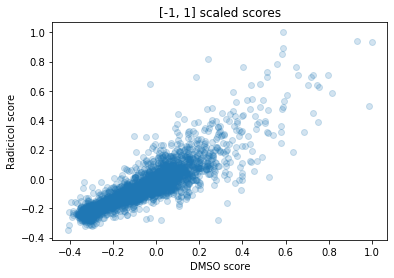

In [12]:
plt.plot(dmso_scores, rad_scores, 'o', alpha=0.2)
plt.xlabel('DMSO score')
plt.ylabel('Radicicol score')
plt.title('Raw scores')
plt.show()

plt.plot(envision_dmso_scores, envision_rad_scores, 'o', alpha=0.2)
plt.xlabel('DMSO score')
plt.ylabel('Radicicol score')
plt.title('Envision scaled scores')
plt.show()

plt.plot(dmso_scores_11, rad_scores_11, 'o', alpha=0.2)
plt.xlabel('DMSO score')
plt.ylabel('Radicicol score')
plt.title('[-1, 1] scaled scores')
plt.show()

## 6a. Look at distributions of differential selection for different scaling measures

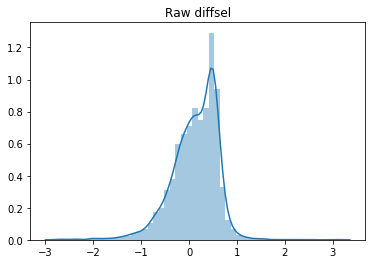

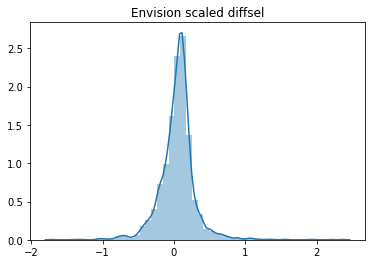

<function matplotlib.pyplot.show(*args, **kw)>

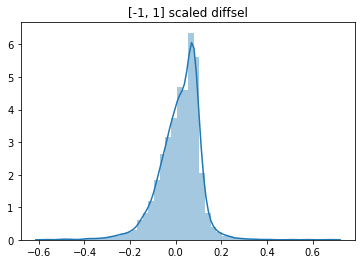

In [13]:
# Differential selection 
envision_diffsel = phillips_scoring(envision_rad_scores, envision_dmso_scores)
oneone_diffsel = phillips_scoring(rad_scores_11, dmso_scores_11)

sns.distplot(diffsel_scores)
plt.title('Raw diffsel')
plt.show()

sns.distplot(envision_diffsel)
plt.title('Envision scaled diffsel')
plt.show()

sns.distplot(oneone_diffsel)
plt.title('[-1, 1] scaled diffsel')
plt.show

In [14]:
envision_resid_scores, _, _ = create_resid_scores_from_array(envision_rad_scores, envision_dmso_scores)

#### Observations: it's easier to see in the histograms that scaling like in VG's Envision paper provides the best overlap of the two distributions. You can slightly see tighter distribution of residuals in the bivariate plots for this kind of scaling

# 7. Compare heatmaps of diffsel and residuals for Envision scaled scores

## 7a. Set up dictionaries and indices for creating heatmaps

In [68]:
aa_key = {
    'His' : 'H',
    'Lys' : 'K',
    'Arg' : 'R',
    'Asp' : 'D',
    'Glu' : 'E',
    'Cys' : 'C',
    'Met' : 'M',
    'Asn' : 'N',
    'Gln' : 'Q',
    'Ser' : 'S',
    'Thr' : 'T',
    'Ala' : 'A',
    'Ile' : 'I',
    'Leu' : 'L',
    'Val' : 'V',
    'Phe' : 'F',
    'Trp' : 'W',
    'Tyr' : 'Y',
    'Gly' : 'G',
    'Pro' : 'P',
    'Ter' : '*'
    
}
variant_index = master.index.tolist()
positions = []
for idx, variant in enumerate(variant_index):
    if 'p.' in variant:
        
        # Get WT, mutant identities and position
        wt_aa = variant[2:5]
        pos = variant[5:-3]
        mut_aa = variant[-3:]
        
        # Create shortened form
        variant_shortened = aa_key[wt_aa] + str(pos) + aa_key[mut_aa]
        
        # Reassign value
        variant_index[idx] = variant_shortened
        
        # Append position to position list to count residues later
        positions.append(pos)
        
# Get number of positions
positions = list(set(positions))
positions.sort()
positions = np.arange(int(min(positions)), int(max(positions)) + 1)

In [69]:
# Create empty np array to place values
heatmap_arr = np.empty((len(positions), len(aa_key)))
heatmap_arr[:] = np.nan

# Create dictionaries that correspond positions and aas to the correct index
pos_idx_dict = dict(zip(positions, np.arange(len(positions))))
aa_idx_dict = dict(zip(list(aa_key.values()), np.arange(len(aa_key))))


## 7b. Create heatmaps for residuals

In [71]:
def create_heatmap_arr(scores, variant_index, pos_idx_dict, aa_idx_dict):
    """
    Create heatmap from given scores.
    
    Args:
        scores: scores in order of variant_index (np array)
        variant_index: order of variants (list)
        pos_idx_dict: dictionary mapping position to heatmap index
        aa_idx_dict: dictionary mapping AA to heatmap index
    Returns:
        heatmap_arr: 2D array where positions=rows, aas=cols
    
    """
    
    # Create empty array for storing values
    heatmap_arr = np.empty((len(pos_idx_dict), len(aa_idx_dict)))
    heatmap_arr[:] = np.nan
    
    # Loop through individual variants
    for variant, score in zip(variant_index, scores):

        # Skip "_wt" and "_sy" rows
        if len(variant) < 5:
            continue

        # Collect wt, mutant, and position data from variant_index
        wt_aa = variant[0]
        pos = variant[1:-1]
        mut_aa = variant[-1]

        # Assign score to heatmap array
        row_idx = pos_idx_dict[int(pos)]
        col_idx = aa_idx_dict[mut_aa]
        heatmap_arr[row_idx, col_idx] = score
        
    return(heatmap_arr)
    
resid_heatmap = create_heatmap_arr(resid_scores, variant_index, pos_idx_dict, aa_idx_dict)
envision_resid_heatmap = create_heatmap_arr(envision_resid_scores, variant_index, pos_idx_dict, aa_idx_dict)

diffsel_heatmap = create_heatmap_arr(diffsel_scores, variant_index, pos_idx_dict, aa_idx_dict)
envision_diffsel_heatmap = create_heatmap_arr(envision_diffsel, variant_index, pos_idx_dict, aa_idx_dict)

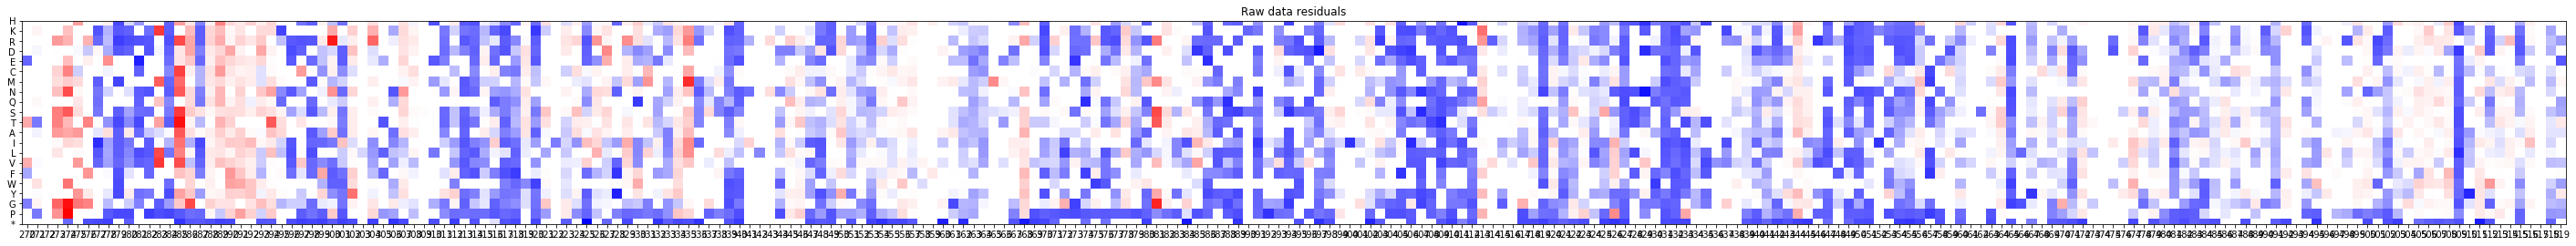

In [72]:
fig, ax = plt.subplots(figsize=(50,300))
resid_map = plt.imshow(resid_heatmap.T, cmap='bwr', norm=DivergingNorm(0.0))

# Set tick locations
ax.set_yticks(np.arange(resid_heatmap.shape[1]))
ax.set_xticks(np.arange(resid_heatmap.shape[0]))

# Set tick labels
ax.set_yticklabels(aa_idx_dict.keys())
ax.set_xticklabels(pos_idx_dict.keys())
plt.title('Raw data residuals')
plt.show()

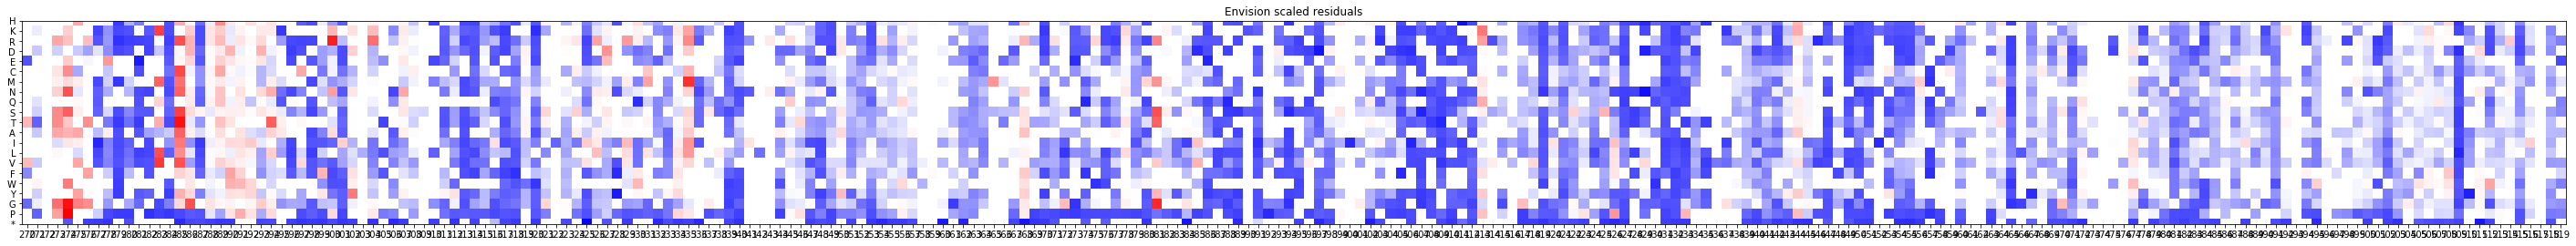

In [73]:
fig, ax = plt.subplots(figsize=(50,300))
plt.imshow(envision_resid_heatmap.T, cmap='bwr', norm=DivergingNorm(0.0))

# Set tick locations
ax.set_yticks(np.arange(resid_heatmap.shape[1]))
ax.set_xticks(np.arange(resid_heatmap.shape[0]))

# Set tick labels
ax.set_yticklabels(aa_idx_dict.keys())
ax.set_xticklabels(pos_idx_dict.keys())
plt.title('Envision scaled residuals')
plt.show()

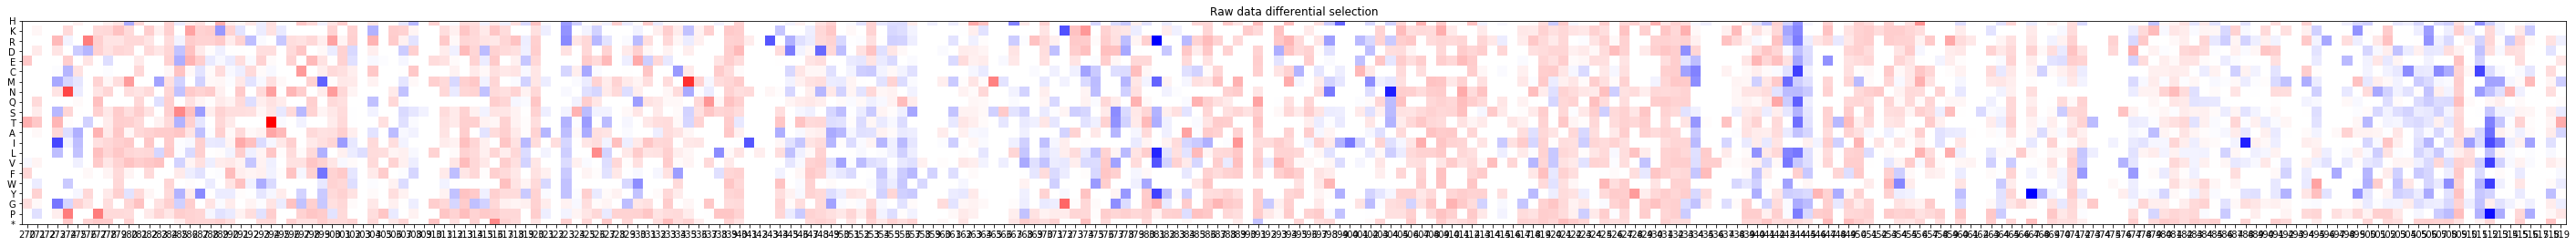

In [74]:
fig, ax = plt.subplots(figsize=(50,300))
resid_map = plt.imshow(diffsel_heatmap.T, cmap='bwr', norm=DivergingNorm(0.0))

# Set tick locations
ax.set_yticks(np.arange(resid_heatmap.shape[1]))
ax.set_xticks(np.arange(resid_heatmap.shape[0]))

# Set tick labels
ax.set_yticklabels(aa_idx_dict.keys())
ax.set_xticklabels(pos_idx_dict.keys())
plt.title('Raw data differential selection')
plt.show()

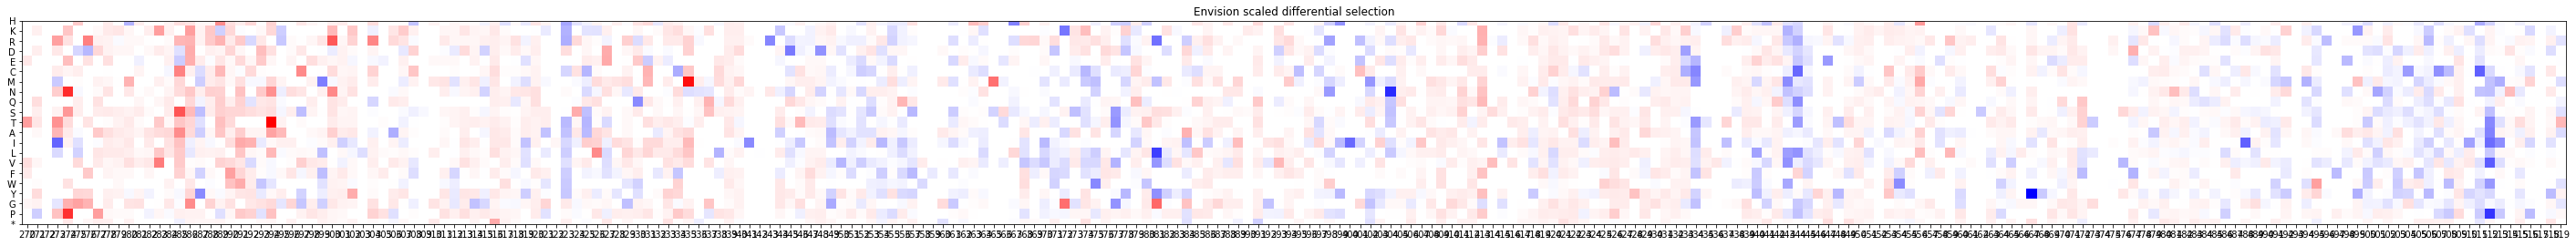

In [75]:
fig, ax = plt.subplots(figsize=(50,300))
resid_map = plt.imshow(envision_diffsel_heatmap.T, cmap='bwr', norm=DivergingNorm(0.0))

# Set tick locations
ax.set_yticks(np.arange(resid_heatmap.shape[1]))
ax.set_xticks(np.arange(resid_heatmap.shape[0]))

# Set tick labels
ax.set_yticklabels(aa_idx_dict.keys())
ax.set_xticklabels(pos_idx_dict.keys())
plt.title('Envision scaled differential selection')
plt.show()

# 8. Save files for later

#### I want the differential selection and residuals for [raw, Envision] scaled scores

In [76]:
# Residuals DF
residuals = np.concatenate(
    (
        np.expand_dims(resid_scores, axis=-1),
        np.expand_dims(envision_resid_scores, axis=-1)
    ),
    axis=-1)
residuals_df = pd.DataFrame(residuals, index=variant_index)
residuals_df.rename(
    columns=dict(zip(residuals_df.columns.tolist(), ['raw_resids', 'envision_scaled_resids'])),
    inplace=True
)

# Diffsel DF
diffsel = np.concatenate(
    (
        np.expand_dims(diffsel_scores, axis=-1),
        np.expand_dims(envision_diffsel, axis=-1)
    ),
    axis=-1)
diffsel_df = pd.DataFrame(diffsel, index=variant_index)
diffsel_df.rename(
    columns=dict(zip(diffsel_df.columns.tolist(), ['raw_diffsel', 'envision_scaled_diffsel'])),
    inplace=True
)

## 8a. Saving residuals and diffsel DataFrames

In [77]:
residuals_df.to_csv('../utils/residuals.csv')
diffsel_df.to_csv('../utils/diffsel.csv')

## 8b. Save heatmaps

In [78]:
pd.DataFrame(resid_heatmap, index=positions, columns=list(aa_key.values())).to_csv('./heatmaps/raw_resid_heatmap.csv')
pd.DataFrame(envision_resid_heatmap, index=positions, columns=list(aa_key.values())).to_csv('./heatmaps/envision_resid_heatmap.csv')
pd.DataFrame(diffsel_heatmap, index=positions, columns=list(aa_key.values())).to_csv('./heatmaps/raw_diffsel_heatmap.csv')
pd.DataFrame(envision_diffsel_heatmap, index=positions, columns=list(aa_key.values())).to_csv('./heatmaps/envision_diffsel_heatmap.csv')
